## DavisSML Tensorflow Lab 1

Some content is taken from 
- www.tensorflow.org 
- http://rail.eecs.berkeley.edu/deeprlcourse/

To install tensorflow use pip:
`pip install tensorflow`

There are 2 exercises below. Do not use Keras or another high level API.

### Tensors

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

- Tensorflow is based around tensor objects
- Tensors can be symbolic or actual data
- Eager execution actually creates the tensors, not just symbolically.  Without it the Tensors would only be symbolic until a session is started.

In [95]:
tf.enable_eager_execution()

Several types of special tensors are
- tf.Variable : typically parameters in your model
- tf.constant : fixed values (gradients will not be calculated wrt them)
- tf.placeholder : a tensor waiting to be assigned a value; not compatible with eager execution
- tf.SparseTensor : a sparse tensor

In [3]:
# initialize these constants
a = tf.constant(1.0)
b = tf.constant(2.0)

# mathematical operations are defined on tensors
c = a + b

print(c)

tf.Tensor(3.0, shape=(), dtype=float32)


Above are scalars which are order 0 tensors, other types are below:

In [4]:
mammal = tf.Variable("Elephant", tf.string)
ignition = tf.Variable(451, tf.int16)
floating = tf.Variable(3.14159265359, tf.float64)
its_complicated = tf.Variable(12.3 - 4.85j, tf.complex64)

In [5]:
mammal.get_shape()

TensorShape([])

Here are some order 1 tensors of various types:

In [3]:
mystr = tf.Variable(["Hello","World"], tf.string)
cool_numbers  = tf.Variable([3.14159, 2.71828], tf.float32)
first_primes = tf.Variable([2, 3, 5, 7, 11], tf.int32)
its_very_complicated = tf.Variable([12.3 - 4.85j, 7.5 - 6.23j], tf.complex64)

In [4]:
first_primes.get_shape()

TensorShape([Dimension(5)])

The shape of the tensor is like that of numpy arrays, they will tell you the order and dimensions.

In [7]:
its_complicated.get_shape(), its_very_complicated.get_shape()

(TensorShape([]), TensorShape([Dimension(2)]))

In [10]:
beta_init = np.random.uniform(0,1,(32,32,32)) #3-dimension array
betas = [tf.convert_to_tensor(beta_init[0,0,0], dtype=tf.float32),
         tf.convert_to_tensor(beta_init[:,0,0], dtype=tf.float32),
         tf.convert_to_tensor(beta_init[:,:,0], dtype=tf.float32),
         tf.convert_to_tensor(beta_init, dtype=tf.float32)]

[beta.get_shape() for beta in betas]

[TensorShape([]),
 TensorShape([Dimension(32)]),
 TensorShape([Dimension(32), Dimension(32)]),
 TensorShape([Dimension(32), Dimension(32), Dimension(32)])]

In [11]:
beta_init.shape

(32, 32, 32)

Tensor operations input and output tensors, and will cast to a tensor if needed.

In [9]:
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


Even when in eager mode Tensors are different than arrays because
- they are immutable : the data cannot be modified without reassiging the variable
- they can live on GPUs as comfortably as CPUs

Why are they immutable?

You can assign slices to other variables:

In [12]:
X = tf.Variable([[1,2,3],[3,4,5]])
Y = X[:2,:2]

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
Y

<tf.Tensor: id=82, shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]], dtype=int32)>

In [14]:
X.assign([[2,2,3],[3,4,5]]) #change the values by 'assign'

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[2, 2, 3],
       [3, 4, 5]], dtype=int32)>

In [13]:
X, Y #Y will not be changed

(<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
 array([[2, 2, 3],
        [3, 4, 5]], dtype=int32)>,
 <tf.Tensor: id=87, shape=(2, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4]], dtype=int32)>)

In [14]:
beta = tf.convert_to_tensor(beta_init, dtype=tf.float32)
beta.device #???

'/job:localhost/replica:0/task:0/device:CPU:0'

Can use GPU if it is available, because many operations are then parallel, it can be much faster:

In [16]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start
    
  print("10 loops: {:0.2f}ms".format(1000*result))


# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random_uniform([2000, 2000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.test.is_gpu_available():
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random_uniform([2000, 2000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)
else:
  print('GPU unavailable')

On CPU:
10 loops: 955.38ms
On GPU:
10 loops: 0.30ms


### Automatic differentiation

Typically automatic differentiation works behind the scenes in tensorflow, but with gradienttape you can actually interact with the gradients.  When you start the gradienttape, it will start tracking the operations performed and thus can compute gradients.

In this case the resulting gradient is also a tensor:

In [17]:
## simple gradient

print("Running simple gradient ex.")

x = tf.ones((2, 2))
  
with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

dz_dx = t.gradient(z, x) #take the partial detivative with respect to x

print(dz_dx)

Running simple gradient ex.
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


__Exercise 1.__ (5 pts) Below is incomplete code for logistic regression gradient computation.  Fill in the necessary components. 

In [102]:
## logistic regression gradient

print("Running log.reg. ex.")
np.random.seed(5)
n, p = 10,5
X_val = np.random.uniform(0,1,(n,p))
beta_val = np.random.uniform(0,1,(p))
p_val = 1. / (1. + np.exp(-X_val @ beta_val))
y_val = 2*(np.random.uniform(0,1,(n)) < p_val) - 1

### Create X,y,beta tensors of the same shape from the above arrays
X = tf.convert_to_tensor(X_val,dtype=tf.float32)
p= tf.convert_to_tensor(p_val,dtype=tf.float32)
y = tf.convert_to_tensor(y_val,dtype=tf.float32)
beta=tf.convert_to_tensor(beta_val,dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(beta)
    ### create z an order 1, with shape [10], tensor of the (y X \beta) vector.  
    z = tf.multiply(y,tf.tensordot(X,beta,axes = [[1], [0]]))
    lg=tf.reduce_sum(tf.log(tf.add(1,tf.exp(-z))))
    grad = t.gradient(lg, beta)
    ### Matrix multiply is tf.multiply, tf.tensordot is dot product

    ### create a tensor for the sum of - log likelihood (log(1 + exp(-z)))

# calculate the gradient of the loss and print it
# grad = 

print(grad)

Running log.reg. ex.
tf.Tensor([1.2900573 1.6217488 2.3820446 2.7773137 1.0699173], shape=(5,), dtype=float32)


### Sessions

We will leave eager mode, to see how sessions work.

In [ ]:
import os
os._exit(00)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tf_reset_graph():
    try:
        sess.close()
    except:
        pass
    new_graph = tf.Graph()
    return new_graph, tf.Session(graph=new_graph)

def tf_reset_default(): # this function is useful in case you forget run the command sess.close()
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [4]:
tf_graph, sess = tf_reset_graph()

A computation graph contains
- tensors defined in with that graph as default
- operations that relate the tensors

The session is associated with a graph.  Typically, you will be working with a single graph, so you do not have to explicitly associate the operations/tensors to a graph, and can rely on the default.

In [5]:
# define your inputs
with tf_graph.as_default():
    a = tf.constant(1.0)
    b = tf.constant(2.0)

    # do some operations
    c = a + b

# get the result
sess.run(c)

3.0

Notice that the session above is still open and needs to be closed.  If you look at tf_reset, this is what happens in the try: statement.

With a session it makes sense to have placeholder tensors that can be fed data.  You should think of this as taking the place of a constant, where the constant value is determined at run time.

In [6]:
tf_graph, sess = tf_reset_graph()

with tf_graph.as_default():
    # define your inputs
    a = tf.placeholder(dtype=tf.float32, shape=[1], name='a_placeholder')
    b = tf.placeholder(dtype=tf.float32, shape=[1], name='b_placeholder')

    # do some operations
    c = a + b

# get the result
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [2.0], b: [4.0]})

print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

c0 = [3.]
c1 = [6.]


You can allow the placeholder tensor to have variable dimensions by making the dimension input to be None.

In [7]:
sess = tf_reset_default()

# inputs
a = tf.placeholder(dtype=tf.float32, shape=[None], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[None], name='b_placeholder')

# do some operations
c = a + b

# get outputs
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [1.0, 2.0], b: [2.0, 4.0]})

print(a)
print('a shape: {0}'.format(a.get_shape()))
print(b)
print('b shape: {0}'.format(b.get_shape()))
print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

Tensor("a_placeholder:0", shape=(?,), dtype=float32)
a shape: (?,)
Tensor("b_placeholder:0", shape=(?,), dtype=float32)
b shape: (?,)
c0 = [3.]
c1 = [3. 6.]


Layers are operations that add variables to the default graph.  They are used to make the code more concise and development easier.  The following Dense layer will add a scalar coefficient and an intercept.

Optimizers are operations that build out the compute graph for a stochastic gradient descent algorithm.  It will create the necessary tensors to make gradient steps, and can be standard SGD, RMSprop, Adam, etc.

In [8]:
sess = tf_reset_default()

## Silly data
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)

"""
This layer implements the operation: outputs = activation(inputs * coefficient + intercept) 
Where activation is the activation function passed as the activation argument (if not None), 
kernel (coefficient) is a weights matrix created by the layer, 
and bias (intercept) is a bias vector created by the layer (only if use_bias is True).

The layer is an operation with variables (to be seen)
"""
linear_model = tf.layers.Dense(units=1)


"""
Apply the linear_model operation to tensor x to produce tensor y_pred
"""
y_pred = linear_model(x)

"""
Losses are output scalar tensors and can accept weights, etc.
"""
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

"""
Can either use a scalar learning rate or tensor (I want to change mine so I use a tensor)
"""
learning_rate = tf.placeholder(tf.float32, shape=[])


"""
train module contains optimizers such as AdaGrad and Adam
- contains methods: apply_gradients, compute_gradients, variables, minimize
- minimize returns an operation that minimizes the input (loss) tensor 
"""
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

"""
You can initialize variables by hand or just use random starts like below
"""
init = tf.global_variables_initializer()


"""
TensorFlow uses the tf.Session class to represent a connection between the client program---typically a Python program, although a similar interface is available in other languages---and the C++ runtime. A tf.Session object provides access to devices in the local machine, and remote devices using the distributed TensorFlow runtime. It also caches information about your tf.Graph so that you can efficiently run the same computation multiple times.

- the session should be closed to free up the device, or even better, use the with clause.
- the run method will execute the subgraph in order to evaluate the tensor or run the operation.
"""

sess.run(init)

for i in range(100):
    lr = .5*(i+1)**-1.
    _, loss_value = sess.run((train, loss), feed_dict={learning_rate : lr})
    print(loss_value)

Instructions for updating:
Use tf.cast instead.
39.939686
2132.094
21491.684
68356.64
80853.66
36301.93
5570.4497
207.48602
0.60352784
0.20137654
0.19343956
0.18815888
0.18349086
0.17928913
0.17547551
0.17199062
0.16878736
0.16582796
0.16308118
0.1605216
0.1581277
0.15588135
0.1537672
0.15177214
0.14988475
0.14809515
0.14639476
0.14477597
0.14323206
0.14175718
0.14034602
0.13899386
0.13769649
0.13645008
0.13525121
0.13409674
0.13298386
0.13190995
0.13087273
0.12987001
0.12889977
0.12796026
0.12704971
0.1261667
0.12530965
0.12447735
0.12366853
0.122881986
0.12211673
0.12137173
0.120646074
0.11993885
0.11924934
0.11857664
0.11792013
0.1172791
0.116652966
0.116041064
0.11544282
0.11485776
0.11428536
0.11372512
0.11317662
0.11263941
0.11211311
0.1115973
0.11109163
0.110595785
0.11010939
0.10963213
0.10916376
0.10870392
0.10825236
0.10780886
0.10737312
0.106944926
0.10652405
0.10611025
0.1057034
0.10530316
0.104909435
0.10452205
0.10414077
0.10376549
0.10339595
0.10303208
0.102673754
0.1023

In [9]:
print(sess.run(y_pred))
print(sess.run(linear_model.weights))

[[-0.50589305]
 [-1.2451398 ]
 [-1.9843866 ]
 [-2.7236333 ]]
[array([[-0.7392468]], dtype=float32), array([0.23335373], dtype=float32)]


The following example from UC Berkeley CS294, trains a fully connected neural net (with 3 hidden layers) for a dataset (below) with scalar input.

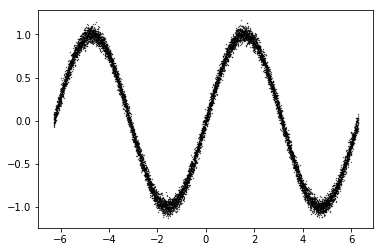

In [10]:
# generate the data
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None]
outputs = np.sin(inputs) + 0.05 * np.random.normal(size=[len(inputs),1])

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')

In [11]:
inputs.shape

(10000, 1)

In [12]:
sess = tf_reset_default()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[1, 20], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[20, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[20], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        print(_)
        saver.save(sess, '/tmp/model.ckpt')

0000 mse: 0.419
None
1000 mse: 0.045
None
2000 mse: 0.016
None
3000 mse: 0.004
None
4000 mse: 0.003
None
5000 mse: 0.003
None
6000 mse: 0.002
None
7000 mse: 0.002
None
8000 mse: 0.001
None
9000 mse: 0.002
None


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


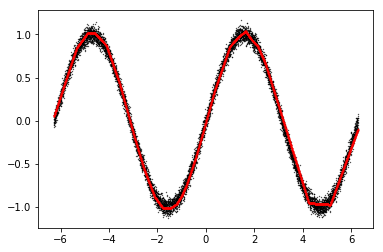

In [13]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

plt.scatter(inputs[:, 0], outputs[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], output_pred_run[:, 0], c='r', marker='o', s=0.1)

In [14]:
n = 10000
X = np.random.uniform(0,1,(n,2))
p = 1 / (1 + np.exp(-5*(X.sum(axis=1) - 2.* (X[:,0] * X[:,1] > .25) - .5)))
y = np.random.uniform(0,1,n) < p

In [15]:
import plotnine as p9
import pandas as pd

In [16]:
XOR_data = pd.DataFrame(X,columns=['X0','X1'])
XOR_data['p'] = p

In [17]:
XOR_data.head()

,X0,X1,p
0,0.066391,0.671050,0.766241
1,0.331891,0.419172,0.778218
2,0.518249,0.639922,0.001218
3,0.962801,0.143595,0.953998
4,0.811384,0.660690,0.005826


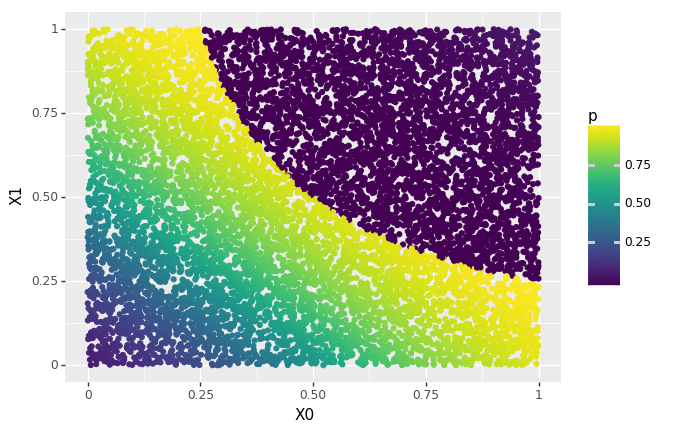

<ggplot: (7563694116)>

In [18]:
p9.ggplot(XOR_data,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

__Exercise 2.__ (15 pts) Create a neural net with dense hidden layers (including intercepts for each hidden unit) and logistic loss function.  Train it on the above dataset with 2 dimensional input using Adam and 32 minibatch size.  You may want to increase the number of iterations until you see convergence.  You can assess visually by plotting the predictions and comparing to the true probability.

1. Try ReLu activation as well as sigmoid activation for 1 hidden layer and 3 units.
2. Try ReLu activation with 2 hidden layers and 3 units each.
3. Try (2) but with any combination of ReLu and Sigmoid activation.

In [27]:
outputs=np.reshape(2*y - 1,(10000,1))
inputs=X

In [68]:
sess = tf_reset_default()

def create_model_relu():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2, 3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[1], initializer=tf.constant_initializer(0.))
    
    weights = [W0, W1]
    biases = [b0, b1]
    activations = [tf.nn.relu, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred= create_model_relu()
# create loss
loss = tf.reduce_mean(tf.log(1+tf.exp(-tf.multiply(output_pred,output_ph))))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(outputs), size=batch_size)
    input_batch = inputs[indices,:]
    output_batch = outputs[indices]
    # run the optimizer and get the mse
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 10000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss_run))
        print(_)
        saver.save(sess, '/tmp/model.ckpt')

0000 loss: 0.688
None
10000 loss: 0.447
None
20000 loss: 0.444
None
30000 loss: 0.382
None
40000 loss: 0.215
None


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
[[ 0.5986373]
 [ 0.5986373]
 [-2.3594978]
 ...
 [ 0.5986373]
 [ 0.5986373]
 [ 0.5986373]]


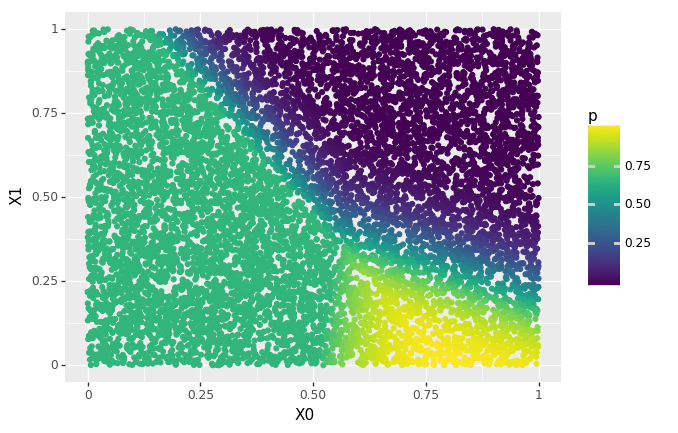

<ggplot: (7563965679)>

In [69]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model_relu()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})
print(output_pred_run)
XOR_1 = pd.DataFrame(X,columns=['X0','X1'])
XOR_1['p'] = 1/(1+np.exp(-output_pred_run))
p9.ggplot(XOR_1,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

### Question 1

__ReLU Activation__

<font color=blue>
    The figure above shows the predictions visually by the model containing 1 hidden layer and 3 units with ReLu activation.
    
   The number of iterations to train the model is 50000. The decreasing loss indicates convergence.
    
   </font>


In [74]:
sess = tf_reset_default()

def create_model_relu():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[2, 3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[1], initializer=tf.constant_initializer(0.))
    
    weights = [W0, W1]
    biases = [b0, b1]
    activations = [tf.sigmoid, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred= create_model_relu()
# create loss
loss = tf.reduce_mean(tf.log(1+tf.exp(-tf.multiply(output_pred,output_ph))))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(outputs), size=batch_size)
    input_batch = inputs[indices,:]
    output_batch = outputs[indices]
    # run the optimizer and get the mse
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 10000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss_run))
        print(_)
        saver.save(sess, '/tmp/model2.ckpt')

0000 loss: 0.690
None
10000 loss: 0.564
None
20000 loss: 0.538
None
30000 loss: 0.432
None
40000 loss: 0.350
None


INFO:tensorflow:Restoring parameters from /tmp/model2.ckpt


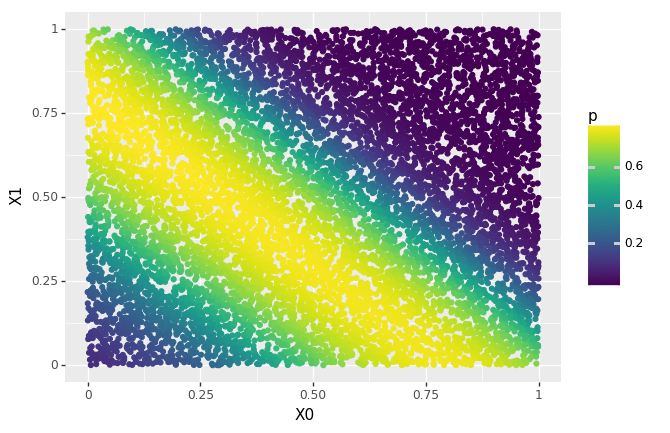

<ggplot: (-9223372029290900017)>

In [75]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model_relu()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model2.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_1 = pd.DataFrame(X,columns=['X0','X1'])
XOR_1['p'] = 1/(1+np.exp(-output_pred_run))
p9.ggplot(XOR_1,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

__Sigmoid Activation__

<font color=blue>
    The figure above shows the predictions visually by the model containing 1 hidden layer and 3 units with sigmoid activation.
    
   The number of iterations to train the model is still 50000. The decreasing loss indicates convergence.
    
   </font>



In [133]:
sess = tf_reset_default()

def create_model_relu():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

     # create variables
    W0 = tf.get_variable(name='W0', shape=[2, 3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 3], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[3], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))
    
    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu,tf.nn.relu, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred= create_model_relu()
# create loss
loss = tf.reduce_mean(tf.log(1+tf.exp(-tf.multiply(output_pred,output_ph))))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(30000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(outputs), size=batch_size)
    input_batch = inputs[indices,:]
    output_batch = outputs[indices]
    # run the optimizer and get the mse
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 10000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss_run))
        print(_)
        saver.save(sess, '/tmp/model3.ckpt')

0000 loss: 1.043
None
10000 loss: 0.581
None
20000 loss: 0.324
None


INFO:tensorflow:Restoring parameters from /tmp/model3.ckpt


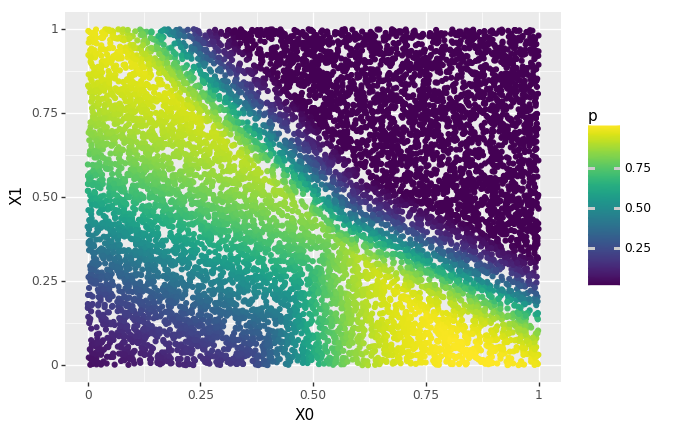

<ggplot: (-9223372029280250827)>

In [134]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model_relu()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model3.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_1 = pd.DataFrame(X,columns=['X0','X1'])
XOR_1['p'] = 1/(1+np.exp(-output_pred_run))
p9.ggplot(XOR_1,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

### Question 2

__2 ReLU Activation__

<font color=blue>
    In this question, the model contains 2 layers and 3 units. Both the 2 layers use ReLU activation.
    
   The figure above versualizes the predictions. 30000 iterations are implemented here to train the model and the decreasing loss also indicates convergence.
   
   </font>

In [66]:
sess = tf_reset_default()

def create_model_relu():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

     # create variables
    W0 = tf.get_variable(name='W0', shape=[2, 3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 3], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[3], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))
    
    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu,tf.sigmoid, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred= create_model_relu()
# create loss
loss = tf.reduce_mean(tf.log(1+tf.exp(-tf.multiply(output_pred,output_ph))))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(outputs), size=batch_size)
    input_batch = inputs[indices,:]
    output_batch = outputs[indices]
    # run the optimizer and get the mse
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 10000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss_run))
        print(_)
        saver.save(sess, '/tmp/model4.ckpt')

0000 loss: 0.691
None
10000 loss: 0.321
None
20000 loss: 0.617
None
30000 loss: 0.700
None
40000 loss: 0.342
None


INFO:tensorflow:Restoring parameters from /tmp/model4.ckpt


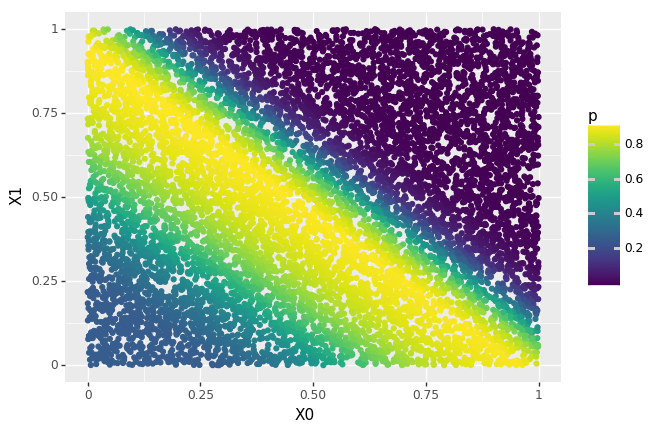

<ggplot: (-9223372029292334136)>

In [67]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model_relu()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model4.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_1 = pd.DataFrame(X,columns=['X0','X1'])
XOR_1['p'] = 1/(1+np.exp(-output_pred_run))
p9.ggplot(XOR_1,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

### Question 3

__Relu and Sigmoid__

<font color=blue>
    This model contains 2 layers and 3 units. And firstly we use ReLU activation, then sigmoid activation.
    
   The figure above versualizes the predictions. The number of iterations is 50000. The loss is decreasing overall, though the fluctuation exists.
   
   </font>

In [39]:
sess = tf_reset_default()

def create_model_relu():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 2])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

     # create variables
    W0 = tf.get_variable(name='W0', shape=[2, 3], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[3, 3], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[3, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[3], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[3], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))
    
    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.sigmoid,tf.nn.relu, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b #linear activation between layers
        if activation is not None:
            layer = activation(layer) #within each layers, apply sefl-defined activation
    output_pred = layer
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred= create_model_relu()
# create loss
loss = tf.reduce_mean(tf.log(1+tf.exp(-tf.multiply(output_pred,output_ph))))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(loss)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(50000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(outputs), size=batch_size)
    input_batch = inputs[indices,:]
    output_batch = outputs[indices]
    # run the optimizer and get the mse
    _, loss_run = sess.run([opt, loss], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} loss: {1:.3f}'.format(training_step, loss_run))
        print(_)
        saver.save(sess, '/tmp/model5.ckpt')

0000 loss: 0.802
None
1000 loss: 0.651
None
2000 loss: 0.685
None
3000 loss: 0.596
None
4000 loss: 0.514
None
5000 loss: 0.490
None
6000 loss: 0.438
None
7000 loss: 0.401
None
8000 loss: 0.385
None
9000 loss: 0.412
None
10000 loss: 0.351
None
11000 loss: 0.307
None
12000 loss: 0.567
None
13000 loss: 0.276
None
14000 loss: 0.328
None
15000 loss: 0.267
None
16000 loss: 0.352
None
17000 loss: 0.531
None
18000 loss: 0.409
None
19000 loss: 0.218
None
20000 loss: 0.240
None
21000 loss: 0.340
None
22000 loss: 0.344
None
23000 loss: 0.210
None
24000 loss: 0.336
None
25000 loss: 0.358
None
26000 loss: 0.206
None
27000 loss: 0.795
None
28000 loss: 0.328
None
29000 loss: 0.341
None
30000 loss: 0.216
None
31000 loss: 0.411
None
32000 loss: 0.315
None
33000 loss: 0.316
None
34000 loss: 0.703
None
35000 loss: 0.606
None
36000 loss: 0.330
None
37000 loss: 0.357
None
38000 loss: 0.381
None
39000 loss: 0.354
None
40000 loss: 0.356
None
41000 loss: 0.264
None
42000 loss: 0.406
None
43000 loss: 0.202
Non

INFO:tensorflow:Restoring parameters from /tmp/model5.ckpt


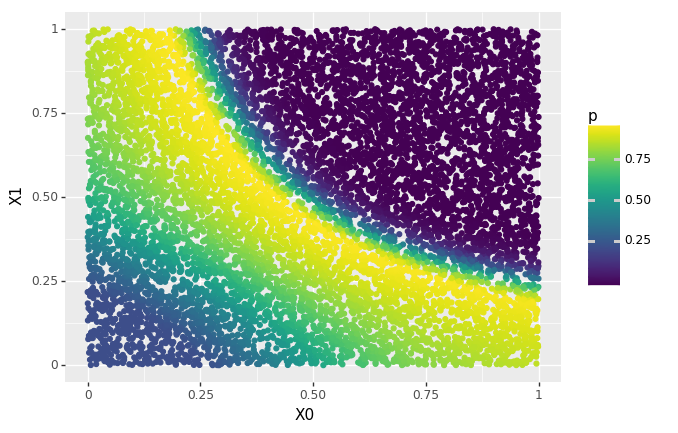

<ggplot: (-9223372029289247765)>

In [40]:
sess = tf_reset_default()

# create the model
input_ph, output_ph, output_pred = create_model_relu()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model5.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

XOR_1 = pd.DataFrame(X,columns=['X0','X1'])
XOR_1['p'] = 1/(1+np.exp(-output_pred_run))
p9.ggplot(XOR_1,p9.aes(x='X0',y='X1',color='p')) + p9.geom_point()

__Sigmoid and Relu__

<font color=blue>
    We still use 2 layers and 3 units but sigmoid activation is used firstly this time, then ReLU activation.
    
   The figure above versualizes the predictions. The number of iterations is still 50000. Similarly, the loss is decreasing overall, though the fluctuation exists.
   
   </font>

In [ ]:
df_raw = pd.read_excel('HZNP_DataScience_Exercise.xlsx',sheet_name = 1)
#change data type
col_names = list(df_raw)
col_names
col_name_num = ["age_at_rf_r1_dx","age_current","HZD_dx_age"] #+data_raw.columns[pd.Series(data_raw.columns).str.startswith('rf_r')].values.tolist()+["px_count_for_HZD_tried","recommend_Product_X"]
col_name_cat = list(set(col_names)-set(col_name_num))

for col in col_name_cat:
    df_raw[col] = df_raw[col].astype('object')
    
feature_df = df_raw.drop(['patientID','recommend_Product_X'], 1)
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
cate_feature = feature_df.select_dtypes(include=['object'])
for i in range(len(list(cate_feature))):
    ind=cate_feature.iloc[:,i][cate_feature.iloc[:,i].isnull()].index
    new_index = pd.Int64Index(np.arange(len(cate_feature))).difference(ind)
    cate_feature.iloc[new_index,i] = LE.fit_transform(cate_feature.iloc[new_index,i])
    cate_feature.iloc[ind,i]=cate_feature.iloc[new_index,i].mean()
feature_df_stand = pd.concat([numerical_feature_stand, cate_feature], axis=1)
X_trdf_stand, X_tedf_stand, y_trdf_stand, y_tedf_stand = train_test_split(feature_df_stand, response_data, test_size=0.22, random_state=4)
outputs_encoding=np.reshape(2*y_trdf_stand.values-1,(y_trdf_stand.shape[0],1))
inputs_encoding=X_trdf_stand.values
inputs_test_encoding=X_tedf_stand.values